In [25]:
import numpy as np
import pandas as pd
import csv
import glob
import igl
import math
import matplotlib.pyplot as plt
import matplotlib.colors
import mpl_toolkits.mplot3d 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
import os

In [31]:
current_dir = os.getcwd()
folder_path = os.path.join(current_dir, "Whale")

path = os.path.join(folder_path, "Blue and fin whales Southern California 2014-2015 - Argos data-reference-data.csv")
with open(path, 'r') as file:
    csvreader = csv.reader(file)
    data = []
    for row in csvreader:
        data.append(row)
    data = np.array(data)

# for file_name in os.listdir(folder_path):
#     if file_name.endswith(".csv"):
#         file_path = os.path.join(folder_path, file_name)
#         with open(file_path, 'r') as file:
#             csvreader = csv.reader(file)
#             for row in csvreader:
#                 # Append the row to the data array, skipping the header row
#                 if csvreader.line_num > 1:
#                     data = np.vstack((data, np.array(row)))

(551, 73)


In [29]:
#Source: https://www.geeksforgeeks.org/how-to-read-all-csv-files-in-a-folder-in-pandas/
# use glob to get all the csv files 
# in the folder
current_dir  = os.getcwd()
csv_files = glob.glob(os.path.join(current_dir, "Whale", "*.csv"))
  
# loop over the list of csv files
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f)
    
    df = np.array(df)

(550,)
(550,)


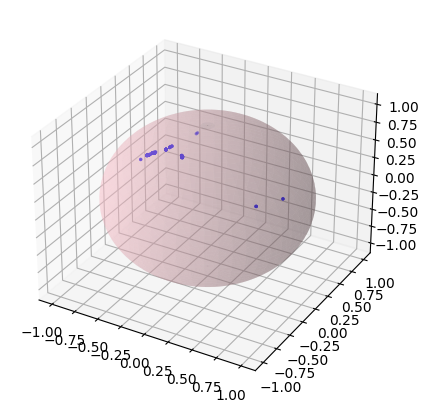

In [37]:
long = data[1:,41]
lat = data[1:,40]

print(long.shape)
print(lat.shape)

# convert to polar coordinates
long = long.astype(float)
lat = 90 - lat.astype(float)

# convert to radians
long = np.deg2rad(long)
lat = np.deg2rad(lat)

# convert to cartesian coordinates
x = np.cos(lat) * np.cos(long)
y = np.cos(lat) * np.sin(long)
z = np.sin(lat)

# Create a sphere
r = 1
u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:50j]
xs = r*np.cos(u)*np.sin(v)
ys = r*np.sin(u)*np.sin(v)
zs = r*np.cos(v)

# plot
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xs, ys, zs, color='pink', alpha=0.3, label='Sphere')
# ax.set_xlim3d(-1, 1)
# ax.set_ylim3d(-1, 1)
# ax.set_zlim3d(-1, 1)
ax.scatter(x, y, z, s=2, color='b', label='Data')
plt.show()